<a href="https://colab.research.google.com/github/YoonyoungChoi/problem_set/blob/main/STA503_Problem_Set6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install arch
!pip install statsmodels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.formula.api import ols
import statsmodels.graphics.tsaplots as sgt
import arch
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from arch import arch_model
import arviz as az
import pymc3 as pm
from scipy.stats import invgamma
import io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Question 1** The dataset RGDPA.txt contains the annual real GDP growth rates for the last 77 years.\
1) What are the mean and standard deviation of the US Real GDP growth over the 77 years? Plot ACF and PACF of the GDP growth rate. Is GDP growth rate predictable, which model do you think would work the best?\
2) Using only the data until 1987 included, estimate an AR(2)
$y_t= \phi_0+\phi_1y_{t-1}_+\phi_2y_{t-2}+\sigma \epsilon_t, \epsilon_t \sim N(0,1)$\
by classical methods, where $y_t=logGDP_t-logGDP_{t-1}.$ Give point estimates of the coefficients and their standard errors.\
3) Is there a cycle at $(\hat{\phi_1},\hat{\phi_2})$?\
4) If you has estimated the AR(2) by Bayesian regression with diffuse priors (in fact any prior with sufficient information of the data) on the parameters, would your numerical results have been different? Would you interpretation of the numerical results have been different? (Mathematical derivation is not required.)\
5) Now you will simulate the predictive distribution of $y_{1988},y_{1989},y_{1990}$. Describe your Monte Carlo algorithm, explaining the steps needed to make on draw of $y_{1988},y_{1989},y_{1990}$. Make 10000 draws. Plot the actual $y_{1988},y_{1989},y_{1990}$ and superimpose your prediction mean and 25 \% and 75 \% percentiles.

1) What are the mean and standard deviation of the US Real GDP growth over the 77 years? Plot ACF and PACF of the GDP growth rate. Is GDP growth rate predictable, which model do you think would work the best?

In [ ]:
# Import data from local PC
from google.colab import files
uploaded = files.upload()
rgdpa = pd.read_csv(io.StringIO(uploaded['RGDPA.txt'].decode('utf-8')), header = None, encoding = 'utf-8-sig')


Saving RGDPA.txt to RGDPA (10).txt


In [ ]:
# Display the raw data
rgdpa.columns=['year']
rdpa=rgdpa.replace(' ','', regex=True)
rgdpa['gdp_growth_rates'] = rgdpa['year'].apply(lambda x: x[4:]).astype(float)
rgdpa['year'] = rgdpa['year'].apply(lambda x: x[0:4]).astype(int)
display(rgdpa)

,year,gdp_growth_rates
0,1930,-9.00421
1,1931,-6.64036
2,1932,-13.92823
3,1933,-1.28207
4,1934,10.26503
...,...,...
72,2002,1.58583
73,2003,2.47878
74,2004,3.57385
75,2005,3.02248


In [ ]:
# About gdp growth rates
gdp_growth_rates_mean=np.mean(rgdpa['gdp_growth_rates'])
print(gdp_growth_rates_mean)
np.dtype(rgdpa['gdp_growth_rates'])
import sys

# Sample Standard Deviation
def sample_std(x):
  return np.sqrt(np.sum(x)-np.mean(x)**2)/(len(x)-1)
print(sample_std(rgdpa['gdp_growth_rates']))

3.3393674025974023
0.20636509017167448


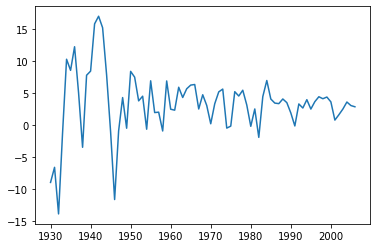

In [ ]:
# In time series data, we need to find out first whether it is normal time series data
# The graph shows that front part of the graph is abnormal because it is between Great Depression and World War II session.
plt.plot(rgdpa['year'],rgdpa['gdp_growth_rates'])
plt.show()

In [ ]:
# Test for find out normality : Augmented Dickey-Fuller Test
# (Caution) H_0: abnormal / H_1: normal
# The result show p-value=0.00 < 0.05 ===> It is normal time series data

result=adfuller(rgdpa['gdp_growth_rates'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key,value))

ADF Statistic: -4.127173
p-value: 0.000873
Critical Values:
	1%: -3.525
	5%: -2.903
	10%: -2.589


In [ ]:
# Normality satisfied but it is suspicious of heteroskedasticity
# Data pre-processing: (1) exclude World War II, (2) seperate the data, during World War II and prior~post World War
# (3) GARCH (conditional heteroskedasticity)
# The data shows difference before and after World War II, heteroskedasticity test for seperated groups

#OLS analys (gdp_growth_rates~1)
model1=ols(formula = 'gdp_growth_rates~1',data=rgdpa[0:17]).fit()
model2=ols(formula = 'gdp_growth_rates~1',data=rgdpa[-17:]).fit()

#Goldfeld-Quandt Test
rss1 = model1.ssr
df_resid1=model1.df_resid

rss2=model2.ssr
df_resid2=model2.df_resid

GQ=(rss1/df_resid1)/(rss2/df_resid2)
print('GQ Test Statistic=', GQ)
#p-value (Prob>F)
1-stats.f.cdf(GQ, df_resid1, df_resid2)

GQ Test Statistic= 60.90770908150478


2.6955548904084026e-11

In [ ]:
# Define the autocovariance and autocorrelation function
def autocovariance(y, N, order, y_mean):
  autocov=0
  for i in np.arange(0, N - order):
    autocov += ((y[i+order])-y_mean) * (y[i]-y_mean)
  return (1/(N-1))*autocov

def autocorrelation(y,N, order, y_mean):
  return autocovariance(y,N,order,y_mean)/autocovariance(y,N,0,y_mean)

In [ ]:
# Setting the Initial value
autocov_result=[]
autocor_result=[]

for i in range(100):
  autocov_result.append(autocovariance(rgdpa['gdp_growth_rates'],len(rgdpa['gdp_growth_rates']),i,
                                       np.mean(rgdpa['gdp_growth_rates'])))
  autocor_result.append(autocorrelation(rgdpa['gdp_growth_rates'],len(rgdpa['gdp_growth_rates']),i,
                                        np.mean(rgdpa['gdp_growth_rates'])))

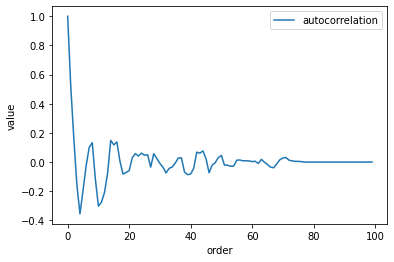

In [ ]:
# Hypothesis test: sequence y_t is not moving average(MA), it is White noise vs. Reject the null hypothesis
# Under null hypothesis (H_0) all theta >=0, autocorrelation factor k follows N(0,1/N) regardless of order k
# Standard Error: 1/np.sqrt(N)

plt.plot(range(100), autocor_result, label='autocorrelation')
plt.xlabel('order')
plt.ylabel('value')
plt.legend()

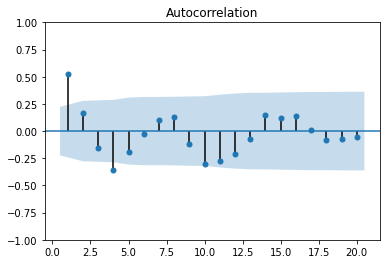

In [ ]:
# Use package statsmodels.graphics.tsaplots as sgt for acf, pacf function
# MA(1)
sgt.plot_acf(rgdpa['gdp_growth_rates'], lags=20, zero=False)
plt.xticks=range(1,21)
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


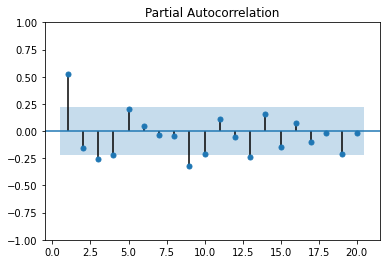

In [ ]:
# AR(1)
sgt.plot_pacf(rgdpa['gdp_growth_rates'], lags=20, zero=False)
plt.xticks=(range(1,21))
plt.show()

In [ ]:
#ARIMA(1,0,0) vs. ARIMA(0,0,1) vs. ARIMA(1,0,1) : ARIMA(1,0,0) is the best
model_arima=SARIMAX(rgdpa['gdp_growth_rates'], order=(1,0,0)) #P, D, Q
model_arima_fit=model_arima.fit(trend='c', full_output= True, methods='css', disp=1)
print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:       gdp_growth_rates   No. Observations:                   77
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -221.817
Date:                Sun, 12 Jun 2022   AIC                            447.635
Time:                        13:49:22   BIC                            452.323
Sample:                             0   HQIC                           449.510
                                 - 77                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6967      0.074      9.384      0.000       0.551       0.842
sigma2        18.4486      2.665      6.922      0.000      13.225      23.672
Ljung-Box (L1) (Q):                   0.24   Jarque-

/usr/local/lib/python3.7/dist-packages/statsmodels/base/optimizer.py:23: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: methods, trend. After release 0.14, this will raise.
  FutureWarning


In [ ]:
# Is it satisfy A5N?
# Shapiro-Wilk Test: Test for Normality

stats.shapiro(model_arima_fit.resid)

(0.972305417060852, 0.09078021347522736)

In [ ]:
# Figure out the fitted value
# resid = calculate by true value - fitted value
rgdpa['fitted'] = rgdpa['gdp_growth_rates'] - model_arima_fit.resid

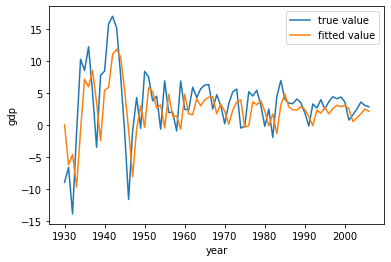

In [ ]:
# Plotting
plt.plot(rgdpa['year'],rgdpa['gdp_growth_rates'], label='true value')
plt.plot(rgdpa['year'],rgdpa['fitted'],label = 'fitted value')
plt.xlabel('year')
plt.ylabel('gdp')
plt.legend()

In [ ]:
# ARCH, GARCH model is also applicapable
# Need to consider whether (1) Is it helpful to interpret the past heteroskedasticity sturcture to forcast the future?
# ARCH, GARCH is model to interpret the present data well vs. ARIMA is the model to forecast the future
# ARCH/GARCH set overweight to the heteroskedastic structure, ARIMA set 1/n overweight to all variables
# (2) Parameter to estimate: ARIMA has smaller number of parameters to estimate compared to ARCH/GARCH 

2) Using only the data until 1987 included, estimate an AR(2)
$y_t= \phi_0+\phi_1y_{t-1}_+\phi_2y_{t-2}+\sigma \epsilon_t, \epsilon_t \sim N(0,1)$

In [ ]:
# y_t = Interpret by GDP growth rates
# Run OLS by Lag Dependent Variable Model
# Caution! ARIMA: AR, MA structue of 'Residual', The solution is run Lag variable model

rgdpa_filtering = rgdpa.loc[rgdpa['year'] <=1987]

In [ ]:
# Run OLS by AR(2)
gdp_1 = list(rgdpa_filtering['gdp_growth_rates'][:-1])
gdp_2 = list(rgdpa_filtering['gdp_growth_rates'][:-2])

In [ ]:
gdp_1.insert(0,0)
# Insert twice
gdp_2.insert(0,0)
gdp_2.insert(0,0)

[0, 0, -9.00421, -6.64036, -13.92823, -1.28207, 10.26503, 8.5294, 12.22211, 5.00752, -3.50717, 7.76176, 8.40882, 15.79976, 16.99145, 15.19188, 7.80289, -1.12448, -11.67899, -0.94188, 4.27078, -0.52474, 8.36972, 7.46223, 3.75624, 4.48475, -0.68036, 6.89348, 1.9246, 1.98826, -0.95628, 6.87062, 2.44798, 2.29968, 5.88584, 4.28235, 5.64564, 6.22202, 6.3145, 2.48426, 4.71134, 3.03875, 0.17248, 3.30387, 5.15882, 5.60142, -0.50571, -0.19465, 5.19089, 4.51246, 5.41835, 3.10967, -0.22641, 2.48736, -1.95407, 4.41979, 6.94033, 4.04697]


58

In [ ]:
# Run OLS using Lag Variable
df=pd.DataFrame({'y_t':rgdpa_filtering['gdp_growth_rates'],'y_t1':gdp_1,'y_t2':gdp_2})
res=ols('y_t~y_t1 + y_t2', data=df).fit()


In [ ]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    y_t   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     12.32
Date:                Sun, 12 Jun 2022   Prob (F-statistic):           3.79e-05
Time:                        14:17:53   Log-Likelihood:                -172.03
No. Observations:                  58   AIC:                             350.1
Df Residuals:                      55   BIC:                             356.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8144      0.765      2.371      0.021       0.281       3.348
y_t1           0.6164      0.133      4.617      0.000       0.349       0.884
y_t2          -0.1335      0.133     -1.003      0.320      -0.400       0.133
==============================================================================
Omnibus:                        2.890   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.236   Jarque-Bera (JB):                2.004
Skew:                          -0.403   Prob(JB):                        0.367
Kurtosis:                       3.423   Cond. No.                         10.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

3) Is there a cycle at $(\hat{\phi_1},\hat{\phi_2})$?

In [ ]:
# Find out the Cycle: In AR(2), it exists when 4*(pi_1)^2 + pi_2 <0
4*(res.params[1]**2) + res.params[2]

1.386140492261051

4) If you has estimated the AR(2) by Bayesian regression with diffuse priors (in fact any prior with sufficient information of the data) on the parameters, would your numerical results have been different? Would you interpretation of the numerical results have been different? (Mathematical derivation is not required.)

In [ ]:
with pm.Model() as model:
  # Setting prior for pi0, pi1, pi2, sigma
  # Selection of prior depends on OLS results
  pi0 = pm.Normal('pi0', res.params[0], res.bse[0]) # Average, standard deviation
  pi1 = pm.Normal('pi1', res.params[1], res.bse[1])
  pi2 = pm.Normal('pi2', res.params[2], res.bse[2])
# In general, in Bayesian Linear Regression, Conjugate Prior of variance uses inverse gamma distribution
# InverseGamma(a,b) : a : (n-k), b=(n-k) * (s**2)/2
  sigma=pm.InverseGamma('sigma',(len(rgdpa_filtering['gdp_growth_rates'])-3)/2,
                        (len(rgdpa_filtering['gdp_growth_rates'])-3) * (res.ssr/res.df_resid)/2)

# Figure out Posterior Predictive Distribution
  pred1_shared = pm.Data('pred1',gdp_1)
  pred2_shared = pm.Data('pred2',gdp_2)

  obs = pm.Normal('obs', res.params[0]+res.params[1]*pred1_shared+res.params[2]*pred2_shared, sigma,
                observed=rgdpa_filtering['gdp_growth_rates'])

# Calculation of Posterior
  trace = pm.sample(draws=5000, tune=2000, chains=2, random_seed=1)
  idata=az.from_pymc3(trace)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, pi2, pi1, pi0]


Sampling 2 chains for 2_000 tune and 5_000 draw iterations (4_000 + 10_000 draws total) took 17 seconds.


In [ ]:
# Region Of Practical Equivalence
# Beyesian credible interval for coefficient (HDI: Highest Density Interval)
# Why coefficient showed by interval? The difference between Frequentist vs. Bayesian
az.summary(trace, var_names=['pi0','pi1','pi2','sigma'], round_to=2)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pi0,1.81,0.78,0.30,3.22,0.01,0.00,15701.59,7330.43,1.0
pi1,0.61,0.14,0.36,0.88,0.00,0.00,16948.42,7278.69,1.0
pi2,-0.13,0.13,-0.40,0.10,0.00,0.00,15528.67,8149.94,1.0
sigma,9.23,0.94,7.56,11.05,0.01,0.01,16436.58,7566.83,1.0


5) Now you will simulate the predictive distribution of $y_{1988},y_{1989},y_{1990}$. Describe your Monte Carlo algorithm, explaining the steps needed to make on draw of $y_{1988},y_{1989},y_{1990}$. Make 10000 draws. Plot the actual $y_{1988},y_{1989},y_{1990}$ and superimpose your prediction mean and 25 \% and 75 \% percentiles.

In [ ]:
# Forecast of year 1988
# Year 1989 -> put the data of year 1987 + forecasted year 1988 (the data for year 1988 varies, simulated value)
# Year 1990 -> put the data of forecasted year 1988, and year 1989
pred1_out_of_sample = np.array([list(rgdpa_filtering['gdp_growth_rates'])[-1]]) #y_1987
pred2_out_of_sample = np.array([list(rgdpa_filtering['gdp_growth_rates'])[-2]]) #y_1986

with model:
  pm.set_data({'pred1': pred1_out_of_sample, 'pred2': pred2_out_of_sample})
  post_pred=pm.sample_posterior_predictive(idata.posterior, random_seed=1)

In [ ]:
print(post_pred['obs'].mean())
print(np.std(post_pred['obs']))
print(post_pred['obs'].mean() - 1.96*np.std(post_pred['obs']))
print(post_pred['obs'].mean() + 1.96*np.std(post_pred['obs']))



3.4180118895552374
9.266077821433743
-14.743500640454897
21.579524419565374


In [ ]:
#True growth rate
rgdpa.loc[rgdpa['year'].isin([1988, 1989, 1990])]

,year,gdp_growth_rates,fitted
58,1988,4.04964,2.313560
59,1989,3.47890,2.821249
60,1990,1.86043,2.423634


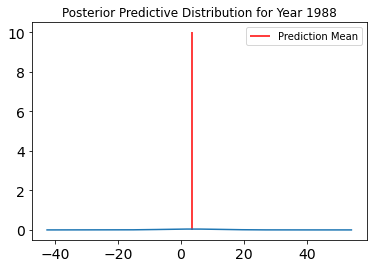

In [ ]:
az.plot_dist(post_pred['obs'])
plt.vlines(post_pred['obs'].mean(), 0, 10, color='red', label='Prediction Mean')
plt.title('Posterior Predictive Distribution for Year 1988')
plt.legend()

/usr/local/lib/python3.7/dist-packages/pymc3/plots/posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,


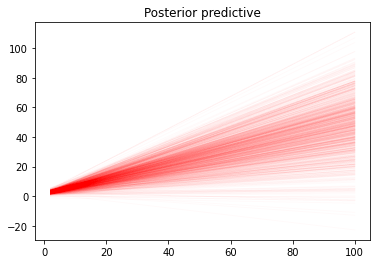

In [ ]:
pm.plot_posterior_predictive_glm(trace, samples=1000, eval=np.linspace(2,100,100),linewidth=1, color='red',alpha=0.02,
                                 label='Bayesian Posterior Models',lm=lambda x, sample: sample['pi0']+sample['pi1']*x+sample['pi2']*x,zorder=1)

In [ ]:
rgdpa.loc[rgdpa['year'].isin([1988,1989,1990])]

,year,gdp_growth_rates,fitted
58,1988,4.04964,2.313560
59,1989,3.47890,2.821249
60,1990,1.86043,2.423634
